Training set size: 35918
Test set size: 8980
Accuracy: 0.9858574610244989

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Top words in Fake news: ['just' 'read' 'image' 'featured' 'gop' 'mr' 'com' 'hillary' 'america'
 'watch' 'getty' 'like' 'obama' 'pic' 'american']
Top words in Real news: ['year' 'edt' 'comment' 'presidential' 'nov' 'minister' 'monday' 'friday'
 'republican' 'tuesday' 'thursday' 'wednesday' 'washington' 'said'
 'reuters']


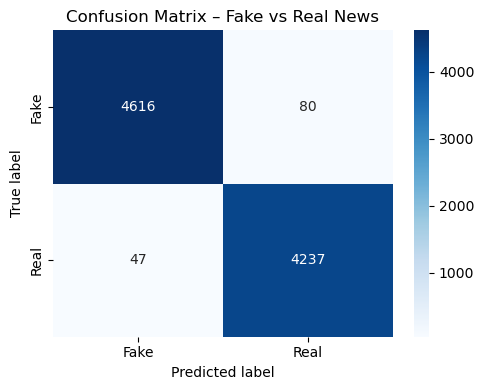

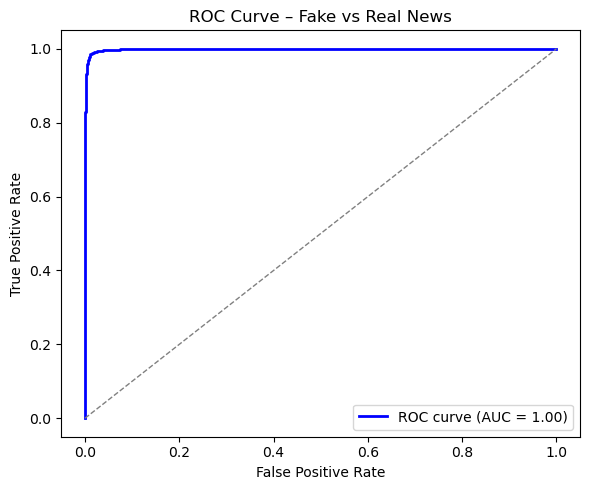


Prediction: Fake News

Prediction: Fake News

Prediction: Fake News
Exiting the program.


In [1]:
# Libraries
import pandas as pd
import numpy as np
import unidecode
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load fake and real news
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

# Label news as 1 or 0
true_df["label"] = 1   # 1 = real
fake_df["label"] = 0   # 0 = fake

# Combine datasets
df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)

# Save merged file (optional)
df.to_csv("merged_fake_real_news.csv", index=False)

# Function to clean text
def clean_text(x):
    x = str(x).lower()
    x = unidecode.unidecode(x)
    return x

# Load merged dataset
df = pd.read_csv("merged_fake_real_news.csv")
df = df[["text", "label"]].dropna()

# Clean text
df["text_clean"] = df["text"].apply(clean_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=5
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_tfidf, y_train)

# Predictions
y_pred = classifier.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

feature_names = np.array(vectorizer.get_feature_names_out())
coef = classifier.coef_[0]

# Top words for fake news (most negative coefficients)
fake_idx = coef.argsort()[:15]
print("Top words in Fake news:", feature_names[fake_idx])

# Top words for real news (most positive coefficients)
real_idx = coef.argsort()[-15:]
print("Top words in Real news:", feature_names[real_idx])

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Fake vs Real News")
plt.tight_layout()
plt.show()

# ROC-AUC curve
y_prob = classifier.predict_proba(X_test_tfidf)[:, 1]  # probability of class 1 (real news)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Fake vs Real News')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# User Input Prediction
def predict_news(text_input):
    text_clean = unidecode.unidecode(str(text_input).lower())
    text_tfidf = vectorizer.transform([text_clean])
    pred_label = classifier.predict(text_tfidf)[0]
    return "Real News" if pred_label==1 else "Fake News"

# Interactive user input
if __name__ == "__main__":
    while True:
        user_input = input("\nEnter a news snippet (or type 'exit' to quit):\n")
        if user_input.lower() == "exit":
            print("Exiting the program.")
            break
        result = predict_news(user_input)
        print(f"\nPrediction: {result}")